## Jupyter notebook for an example Class Activation Map produced from a TensorFlow-based VGG model on the Caltech256 dataset
<br>
### By Masood Krohy (https://github.com/MasoodK)
### Ver.1.0
### Notebook is based on the work/code of Taeksoo Kim (https://github.com/jazzsaxmafia/Weakly_detector)

#### Minor updates done to make the code work with TF v1.2 (these changes are marked with #OldTF). Same for #OldPandas and #OldScikitImage. Some other minor enhancements have also been done to the code.

### Paths and dataset downloads and package imports

Download the following files to your machine and mention the paths in the cell below:
- Caltech256 imageset: http://www.vision.caltech.edu/Image_Datasets/Caltech256/256_ObjectCategories.tar
- Pretrained VGG Network weights: https://drive.google.com/file/d/0B5o40yxdA9PqOVI5dF9tN3NUc2c/view?usp=sharing (link mentioned by Taeksoo Kim)

In [1]:
dataset_path = '/workspace/datasets/caltech256/256_ObjectCategories'
weight_path = '/workspace/trained_models/VGG/caffe_layers_value.pickle'

# The following parameters must be set, as the model is saved to this path after the training:
model_path = '/workspace/trained_models/VGG/'
saved_model_name = 'model-1' # The epoch number gets appended after this, e.g., model-1-1

# This model is used/needed for testing (e.g., one of the above models):
saved_model_name_testing = 'model-1-1'

# The following parameters are optional:
# Loading a pre-trained model before starting the training, if it exists.
pretrained_model = None # None or '/workspace/trained_models/VGG/model-1-1'
# These are created from dataset, if they are not already on disk:
trainset_path = '/workspace/datasets/caltech256/train.pickle'
testset_path = '/workspace/datasets/caltech256/test.pickle'
label_dict_path = '/workspace/datasets/caltech256/label_dict.pickle'

In [2]:
import os
import cPickle
import matplotlib.pyplot as plt
from datetime import datetime
import pytz
import time

import numpy as np
print 'Numpy version: ' + np.__version__

import pandas as pd
print 'Pandas version: ' + pd.__version__

import skimage.io
import skimage.transform
print 'scikit-image version: ' + skimage.__version__

import tensorflow as tf
print 'TensorFlow version: ' + tf.__version__

from tensorflow.python.client import device_lib
def get_available_gpus():
    local_device_protos = device_lib.list_local_devices()
    return [x.physical_device_desc for x in local_device_protos if x.device_type == 'GPU']
print '-------------------------'
print 'GPU info: ' + str(get_available_gpus()[0])
print '-------------------------'

Numpy version: 1.13.0
Pandas version: 0.20.2
scikit-image version: 0.13.0
TensorFlow version: 1.2.0
-------------------------
GPU info: device: 0, name: Tesla K80, pci bus id: 31c8:00:00.0
-------------------------


### The function that loads an image and makes sure it has the size expected by the VGG model

In [3]:
def load_image( path ):
    try:
        img = skimage.io.imread( path ).astype( float )
    except:
        return None

    if img is None: return None
    if len(img.shape) < 2: return None
    if len(img.shape) == 4: return None
    if len(img.shape) == 2: img=np.tile(img[:,:,None], 3)
    if img.shape[2] == 4: img=img[:,:,:3]
    if img.shape[2] > 4: return None

    img /= 255.

    short_edge = min( img.shape[:2] )
    yy = int((img.shape[0] - short_edge) / 2)
    xx = int((img.shape[1] - short_edge) / 2)
    crop_img = img[yy:yy+short_edge, xx:xx+short_edge]
    resized_img = skimage.transform.resize( crop_img, [224,224] , mode='constant')
    '''
    #OldScikitImage
    resized_img = skimage.transform.resize( crop_img, [224,224] )
    '''
    return resized_img

### The class that defines the VGG-GAP model (through the inference fun.) and creates the Class Activation Map

In [4]:
class Detector():
    def __init__(self, weight_file_path, n_labels):
        self.image_mean = [103.939, 116.779, 123.68]
        self.n_labels = n_labels

        with open(weight_file_path) as f:
            self.pretrained_weights = cPickle.load(f)

    def get_weight( self, layer_name):
        layer = self.pretrained_weights[layer_name]
        return layer[0]

    def get_bias( self, layer_name ):
        layer = self.pretrained_weights[layer_name]
        return layer[1]

    def get_conv_weight( self, name ):
        f = self.get_weight( name )
        return f.transpose(( 2,3,1,0 ))

    def conv_layer( self, bottom, name ):
        with tf.variable_scope(name) as scope:

            w = self.get_conv_weight(name)
            b = self.get_bias(name)

            conv_weights = tf.get_variable(
                    "W",
                    shape=w.shape,
                    initializer=tf.constant_initializer(w)
                    )
            conv_biases = tf.get_variable(
                    "b",
                    shape=b.shape,
                    initializer=tf.constant_initializer(b)
                    )

            conv = tf.nn.conv2d( bottom, conv_weights, [1,1,1,1], padding='SAME')
            bias = tf.nn.bias_add( conv, conv_biases )
            relu = tf.nn.relu( bias, name=name )

        return relu

    def new_conv_layer( self, bottom, filter_shape, name ):
        with tf.variable_scope( name ) as scope:
            w = tf.get_variable(
                    "W",
                    shape=filter_shape,
                    initializer=tf.random_normal_initializer(0., 0.01))
            b = tf.get_variable(
                    "b",
                    shape=filter_shape[-1],
                    initializer=tf.constant_initializer(0.))

            conv = tf.nn.conv2d( bottom, w, [1,1,1,1], padding='SAME')
            bias = tf.nn.bias_add(conv, b)

        return bias #relu

    def fc_layer(self, bottom, name, create=False):
        shape = bottom.get_shape().as_list()
        dim = np.prod( shape[1:] )
        x = tf.reshape(bottom, [-1, dim])

        cw = self.get_weight(name)
        b = self.get_bias(name)

        if name == "fc6":
            cw = cw.reshape((4096, 512, 7,7))
            cw = cw.transpose((2,3,1,0))
            cw = cw.reshape((25088,4096))
        else:
            cw = cw.transpose((1,0))

        with tf.variable_scope(name) as scope:
            cw = tf.get_variable(
                    "W",
                    shape=cw.shape,
                    initializer=tf.constant_initializer(cw))
            b = tf.get_variable(
                    "b",
                    shape=b.shape,
                    initializer=tf.constant_initializer(b))

            fc = tf.nn.bias_add( tf.matmul( x, cw ), b, name=scope)

        return fc

    def new_fc_layer( self, bottom, input_size, output_size, name ):
        shape = bottom.get_shape().to_list()
        dim = np.prod( shape[1:] )
        x = tf.reshape( bottom, [-1, dim])

        with tf.variable_scope(name) as scope:
            w = tf.get_variable(
                    "W",
                    shape=[input_size, output_size],
                    initializer=tf.random_normal_initializer(0., 0.01))
            b = tf.get_variable(
                    "b",
                    shape=[output_size],
                    initializer=tf.constant_initializer(0.))
            fc = tf.nn.bias_add( tf.matmul(x, w), b, name=scope)

        return fc

    def inference( self, rgb, train=False ):
        rgb *= 255.
        
        r, g, b = tf.split(rgb, num_or_size_splits=3, axis=3)
        bgr = tf.concat(
            [
                b-self.image_mean[0],
                g-self.image_mean[1],
                r-self.image_mean[2]
            ], axis=3)
        '''
        #OldTF
        r, g, b = tf.split(3, 3, rgb)
        bgr = tf.concat(3,
            [
                b-self.image_mean[0],
                g-self.image_mean[1],
                r-self.image_mean[2]
            ])
        '''

        relu1_1 = self.conv_layer( bgr, "conv1_1" )
        relu1_2 = self.conv_layer( relu1_1, "conv1_2" )

        pool1 = tf.nn.max_pool(relu1_2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1],
                                         padding='SAME', name='pool1')

        relu2_1 = self.conv_layer(pool1, "conv2_1")
        relu2_2 = self.conv_layer(relu2_1, "conv2_2")
        pool2 = tf.nn.max_pool(relu2_2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1],
                               padding='SAME', name='pool2')

        relu3_1 = self.conv_layer( pool2, "conv3_1")
        relu3_2 = self.conv_layer( relu3_1, "conv3_2")
        relu3_3 = self.conv_layer( relu3_2, "conv3_3")
        pool3 = tf.nn.max_pool(relu3_3, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1],
                               padding='SAME', name='pool3')

        relu4_1 = self.conv_layer( pool3, "conv4_1")
        relu4_2 = self.conv_layer( relu4_1, "conv4_2")
        relu4_3 = self.conv_layer( relu4_2, "conv4_3")
        pool4 = tf.nn.max_pool(relu4_3, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1],
                               padding='SAME', name='pool4')

        relu5_1 = self.conv_layer( pool4, "conv5_1")
        relu5_2 = self.conv_layer( relu5_1, "conv5_2")
        relu5_3 = self.conv_layer( relu5_2, "conv5_3")

        conv6 = self.new_conv_layer( relu5_3, [3,3,512,1024], "conv6")
        gap = tf.reduce_mean( conv6, [1,2] )

        with tf.variable_scope("GAP"):
            gap_w = tf.get_variable(
                    "W",
                    shape=[1024, self.n_labels],
                    initializer=tf.random_normal_initializer(0., 0.01))

        output = tf.matmul( gap, gap_w)

        return pool1, pool2, pool3, pool4, relu5_3, conv6, gap, output

    def get_classmap(self, label, conv6):
        conv6_resized = tf.image.resize_bilinear( conv6, [224, 224] )
        with tf.variable_scope("GAP", reuse=True):
            label_w = tf.gather(tf.transpose(tf.get_variable("W")), label)
            label_w = tf.reshape( label_w, [-1, 1024, 1] ) # [batch_size, 1024, 1]

        conv6_resized = tf.reshape(conv6_resized, [-1, 224*224, 1024]) # [batch_size, 224*224, 1024]

        classmap = tf.matmul( conv6_resized, label_w )
        '''
        #OldTF
        classmap = tf.batch_matmul( conv6_resized, label_w )
        '''
        
        classmap = tf.reshape( classmap, [-1, 224,224] )
        return classmap

### Training: initializing the model with the pretrained weights and continuing the training

In [5]:
# Creating or loading the sets (train/test/labels):

if not os.path.exists( trainset_path ):
    print 'Starting to process the dataset and building the train, test, and label sets (only paths to the images) ...'
    image_dir_list = os.listdir( dataset_path )

    label_pairs = map(lambda x: x.split('.'), image_dir_list)
    labels, label_names = zip(*label_pairs)
    labels = map(lambda x: int(x), labels)

    label_dict = pd.Series( labels, index=label_names )
    label_dict -= 1
    n_labels = len( label_dict )

    image_paths_per_label = map(lambda one_dir: map(lambda one_file: os.path.join( dataset_path, one_dir, one_file ), os.listdir( os.path.join( dataset_path, one_dir))), image_dir_list)
    image_paths_train = np.hstack(map(lambda one_class: one_class[:-10], image_paths_per_label))
    image_paths_test = np.hstack(map(lambda one_class: one_class[-10:], image_paths_per_label))

    trainset = pd.DataFrame({'image_path': image_paths_train})
    testset  = pd.DataFrame({'image_path': image_paths_test })

    trainset = trainset[ trainset['image_path'].map( lambda x: x.endswith('.jpg'))]
    trainset['label'] = trainset['image_path'].map(lambda x: int(x.split('/')[-2].split('.')[0]) - 1)
    trainset['label_name'] = trainset['image_path'].map(lambda x: x.split('/')[-2].split('.')[1])

    testset = testset[ testset['image_path'].map( lambda x: x.endswith('.jpg'))]
    testset['label'] = testset['image_path'].map(lambda x: int(x.split('/')[-2].split('.')[0]) - 1)
    testset['label_name'] = testset['image_path'].map(lambda x: x.split('/')[-2].split('.')[1])

    label_dict.to_pickle(label_dict_path)
    trainset.to_pickle(trainset_path)
    testset.to_pickle(testset_path)
    print 'Processed the dataset and pickled to disk: trainset, testset, and label_dict'
else:
    trainset = pd.read_pickle( trainset_path )
    testset  = pd.read_pickle( testset_path )
    label_dict = pd.read_pickle( label_dict_path )
    print 'Read from disk: trainset, testset, and label_dict'
    n_labels = len(label_dict)


print 'Train set size: ' + str(len(trainset))
print 'Test set size: ' + str(len(testset))    

Read from disk: trainset, testset, and label_dict
Train set size: 28037
Test set size: 2570


In [10]:
n_epochs = 2 # 10000
init_learning_rate = 0.01
weight_decay_rate = 0.0005
momentum = 0.9
batch_size = 60
max_iterations_per_epoch = -1 # use if you want to end the training prematurely (set to -1 to remove the max)

now = datetime.now(pytz.timezone('US/Eastern'))
seconds_since_epoch_start = time.mktime(now.timetuple())

graph = tf.Graph()
with graph.as_default():
    learning_rate = tf.placeholder( tf.float32, [])
    images_tf = tf.placeholder( tf.float32, [None, 224, 224, 3], name="images")
    labels_tf = tf.placeholder( tf.int64, [None], name='labels')

    detector = Detector(weight_path, n_labels)

    p1,p2,p3,p4,conv5, conv6, gap, output = detector.inference(images_tf)
    loss_tf = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(labels=labels_tf, logits=output))
    '''
    #OldTF
    loss_tf = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits( output, labels_tf ))
    '''

    weights_only = filter( lambda x: x.name.endswith('W:0'), tf.trainable_variables() )
    weight_decay = tf.reduce_sum(tf.stack([tf.nn.l2_loss(x) for x in weights_only])) * weight_decay_rate
    '''
    #OldTF
    weight_decay = tf.reduce_sum(tf.pack([tf.nn.l2_loss(x) for x in weights_only])) * weight_decay_rate
    '''

    loss_tf += weight_decay

    saver = tf.train.Saver( max_to_keep=50 )

    optimizer = tf.train.MomentumOptimizer( learning_rate, momentum )
    grads_and_vars = optimizer.compute_gradients( loss_tf )
    grads_and_vars = map(lambda gv: (gv[0], gv[1]) if ('conv6' in gv[1].name or 'GAP' in gv[1].name) else (gv[0]*0.1, gv[1]), grads_and_vars)
    #grads_and_vars = [(tf.clip_by_value(gv[0], -5., 5.), gv[1]) for gv in grads_and_vars]
    train_op = optimizer.apply_gradients( grads_and_vars )
    
with tf.Session(graph=graph) as sess:    
    tf.global_variables_initializer().run()
    '''
    #OldTF
    tf.initialize_all_variables().run()
    '''

    if pretrained_model:
        print 'Pretrained model loaded from ' + pretrained_model + ' (this overwrites the initial weights loaded to the model)'
        saver.restore(sess, pretrained_model)

    testset.index  = range( len(testset) )

    iterations = 0
    loss_list = []
    print 'Starting the training ...'
    for epoch in range(n_epochs):
        trainset.index = range( len(trainset) )
        trainset = trainset.loc[ np.random.permutation( len(trainset) )]
        '''
        #OldPandas
        trainset = trainset.ix[ np.random.permutation( len(trainset) )]
        '''

        for start, end in zip(
            range( 0, len(trainset)+batch_size, batch_size),
            range(batch_size, len(trainset)+batch_size, batch_size)):

            current_data = trainset[start:end]
            current_image_paths = current_data['image_path'].values
            current_images = np.array(map(lambda x: load_image(x), current_image_paths))

            good_index = np.array(map(lambda x: x is not None, current_images))

            current_data = current_data[good_index]
            current_images = np.stack(current_images[good_index])
            current_labels = current_data['label'].values

            _, loss_val, output_val = sess.run(
                    [train_op, loss_tf, output],
                    feed_dict={
                        learning_rate: init_learning_rate,
                        images_tf: current_images,
                        labels_tf: current_labels
                        })

            loss_list.append( loss_val )

            iterations += 1
            if iterations % 5 == 0:
                print "======================================"
                print "Epoch", epoch + 1, "Iteration", iterations
                print "Processed", start, '/', len(trainset)

                label_predictions = output_val.argmax(axis=1)
                acc = (label_predictions == current_labels).sum()

                print "Accuracy:", acc, '/', len(current_labels)
                print "Training Loss:", np.mean(loss_list)
                #print "\n"
                loss_list = []

            if iterations > max_iterations_per_epoch and max_iterations_per_epoch != -1:
                iterations = 0
                break

        n_correct = 0
        n_data = 0
        for start, end in zip(
                range(0, len(testset)+batch_size, batch_size),
                range(batch_size, len(testset)+batch_size, batch_size)
                ):
            current_data = testset[start:end]
            current_image_paths = current_data['image_path'].values
            current_images = np.array(map(lambda x: load_image(x), current_image_paths))

            good_index = np.array(map(lambda x: x is not None, current_images))

            current_data = current_data[good_index]
            current_images = np.stack(current_images[good_index])
            current_labels = current_data['label'].values

            output_vals = sess.run(
                    output,
                    feed_dict={images_tf:current_images})

            label_predictions = output_vals.argmax(axis=1)
            acc = (label_predictions == current_labels).sum()

            n_correct += acc
            n_data += len(current_data)

        acc_all = n_correct / float(n_data)
        print "$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$"
        print 'Model evaluation on the test set:'
        print 'Epoch:'+str(epoch + 1)+'\tacc:'+str(acc_all)
        print "$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$"

        saver.save( sess, os.path.join( model_path, saved_model_name), global_step=epoch)

        init_learning_rate *= 0.99
    
now = datetime.now(pytz.timezone('US/Eastern'))
seconds_since_epoch_end = time.mktime(now.timetuple())
print 'Processing took ' + str( np.around( (seconds_since_epoch_end - seconds_since_epoch_start)/60.0 , decimals=1) ) + ' minutes.'

Starting the training ...
Epoch 1 Iteration 5
Processed 240 / 28037
Accuracy: 7 / 60
Training Loss: 5.94978
Epoch 1 Iteration 10
Processed 540 / 28037
Accuracy: 18 / 60
Training Loss: 5.33977
Epoch 1 Iteration 15
Processed 840 / 28037
Accuracy: 17 / 60
Training Loss: 4.47088
Epoch 1 Iteration 20
Processed 1140 / 28037
Accuracy: 24 / 60
Training Loss: 3.94234
Epoch 1 Iteration 25
Processed 1440 / 28037
Accuracy: 24 / 60
Training Loss: 3.52931
Epoch 1 Iteration 30
Processed 1740 / 28037
Accuracy: 21 / 60
Training Loss: 3.64857
Epoch 1 Iteration 35
Processed 2040 / 28037
Accuracy: 23 / 60
Training Loss: 3.25359
Epoch 1 Iteration 40
Processed 2340 / 28037
Accuracy: 31 / 60
Training Loss: 3.14784
Epoch 1 Iteration 45
Processed 2640 / 28037
Accuracy: 35 / 60
Training Loss: 2.69925
Epoch 1 Iteration 50
Processed 2940 / 28037
Accuracy: 29 / 60
Training Loss: 2.57009
Epoch 1 Iteration 55
Processed 3240 / 28037
Accuracy: 26 / 60
Training Loss: 3.12582
Epoch 1 Iteration 60
Processed 3540 / 28037


Epoch 1 Iteration 335
Processed 20040 / 28037
Accuracy: 41 / 60
Training Loss: 2.01132
Epoch 1 Iteration 340
Processed 20340 / 28037
Accuracy: 47 / 60
Training Loss: 1.88114
Epoch 1 Iteration 345
Processed 20640 / 28037
Accuracy: 48 / 60
Training Loss: 2.09316
Epoch 1 Iteration 350
Processed 20940 / 28037
Accuracy: 39 / 60
Training Loss: 1.73015
Epoch 1 Iteration 355
Processed 21240 / 28037
Accuracy: 35 / 60
Training Loss: 1.75347
Epoch 1 Iteration 360
Processed 21540 / 28037
Accuracy: 41 / 60
Training Loss: 1.75822
Epoch 1 Iteration 365
Processed 21840 / 28037
Accuracy: 37 / 60
Training Loss: 1.77201
Epoch 1 Iteration 370
Processed 22140 / 28037
Accuracy: 48 / 60
Training Loss: 1.89528
Epoch 1 Iteration 375
Processed 22440 / 28037
Accuracy: 45 / 60
Training Loss: 1.89892
Epoch 1 Iteration 380
Processed 22740 / 28037
Accuracy: 42 / 60
Training Loss: 1.62839
Epoch 1 Iteration 385
Processed 23040 / 28037
Accuracy: 38 / 60
Training Loss: 1.76019
Epoch 1 Iteration 390
Processed 23340 / 280

Epoch 2 Iteration 660
Processed 11460 / 28037
Accuracy: 52 / 60
Training Loss: 1.31783
Epoch 2 Iteration 665
Processed 11760 / 28037
Accuracy: 42 / 60
Training Loss: 1.53452
Epoch 2 Iteration 670
Processed 12060 / 28037
Accuracy: 50 / 60
Training Loss: 1.25394
Epoch 2 Iteration 675
Processed 12360 / 28037
Accuracy: 46 / 60
Training Loss: 1.34181
Epoch 2 Iteration 680
Processed 12660 / 28037
Accuracy: 46 / 60
Training Loss: 1.53358
Epoch 2 Iteration 685
Processed 12960 / 28037
Accuracy: 44 / 60
Training Loss: 1.28749
Epoch 2 Iteration 690
Processed 13260 / 28037
Accuracy: 49 / 60
Training Loss: 1.28624
Epoch 2 Iteration 695
Processed 13560 / 28037
Accuracy: 47 / 60
Training Loss: 1.1609
Epoch 2 Iteration 700
Processed 13860 / 28037
Accuracy: 46 / 60
Training Loss: 1.4162
Epoch 2 Iteration 705
Processed 14160 / 28037
Accuracy: 42 / 60
Training Loss: 1.35968
Epoch 2 Iteration 710
Processed 14460 / 28037
Accuracy: 54 / 60
Training Loss: 1.37491
Epoch 2 Iteration 715
Processed 14760 / 28037

### Producing the Class Activation Map for the samples in the test set

INFO:tensorflow:Restoring parameters from /workspace/trained_models/VGG/model-1-1
frog


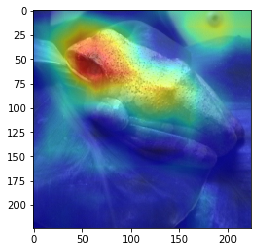

fighter-jet


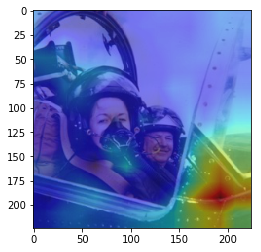

head-phones


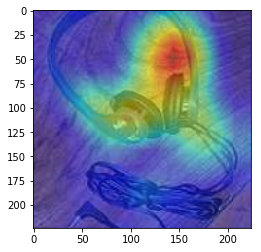

centipede


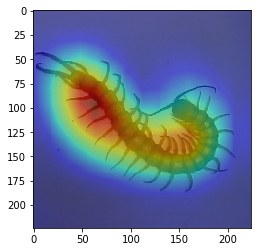

lightbulb


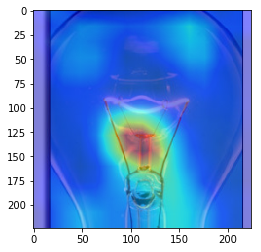

chopsticks


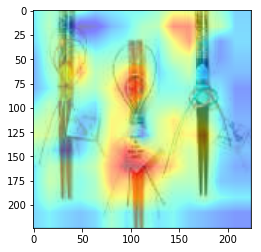

coin


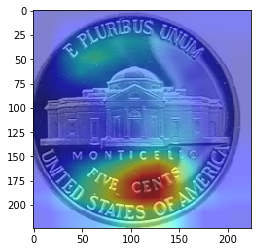

doorknob


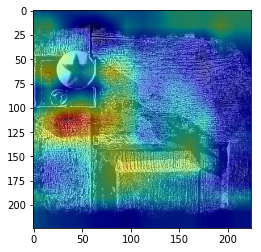

conch


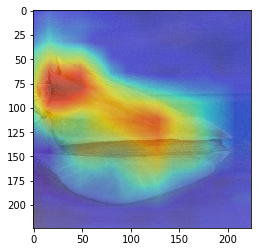

skateboard


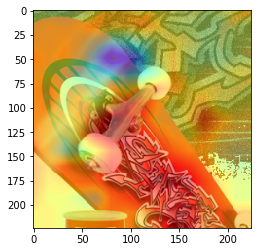

In [9]:
# Reading the testset, creating the graph, and restoring the trained model:

num_cam_images = 10 # Number of images randomly selected for which we are producing the CAM

batch_size = 1

testset = pd.read_pickle( testset_path )#[::-1][:20]
label_dict = pd.read_pickle( label_dict_path )
n_labels = len( label_dict )

random_selection = np.random.randint(0, len(testset) - batch_size , size=num_cam_images)

graph = tf.Graph()
with graph.as_default():
    images_tf = tf.placeholder( tf.float32, [None, 224, 224, 3], name="images")
    labels_tf = tf.placeholder( tf.int64, [None], name='labels')

    detector = Detector( weight_path, n_labels )
    c1,c2,c3,c4,conv5, conv6, gap, output = detector.inference( images_tf )

    saver = tf.train.Saver()
    
    classmap = detector.get_classmap( labels_tf, conv6 )

with tf.Session(graph=graph) as sess:    
    
    saver.restore( sess, os.path.join( model_path, saved_model_name_testing) )

    for start, end in zip(
        random_selection,
        list(random_selection + batch_size)):
        '''
        range( 0, len(testset)+batch_size, batch_size),
        range(batch_size, len(testset)+batch_size, batch_size)):

        if end >= num_cam_images:
            break
        '''

        current_data = testset[start:end]
        current_image_paths = current_data['image_path'].values
        current_images = np.array(map(lambda x: load_image(x), current_image_paths))

        good_index = np.array(map(lambda x: x is not None, current_images))

        current_data = current_data[good_index]
        current_image_paths = current_image_paths[good_index]
        current_images = np.stack(current_images[good_index])
        current_labels = current_data['label'].values
        current_label_names = current_data['label_name'].values

        conv6_val, output_val = sess.run(
                [conv6, output],
                feed_dict={
                    images_tf: current_images
                    })

        label_predictions = output_val.argmax( axis=1 )
        acc = (label_predictions == current_labels).sum()

        classmap_vals = sess.run(
                classmap,
                feed_dict={
                    labels_tf: label_predictions,
                    conv6: conv6_val
                    })

        classmap_answer = sess.run(
                classmap,
                feed_dict={
                    labels_tf: current_labels,
                    conv6: conv6_val
                    })

        classmap_vis = map(lambda x: ((x-x.min())/(x.max()-x.min())), classmap_answer)

        print "======================================"
        for vis, ori,ori_path, l_name in zip(classmap_vis, current_images, current_image_paths, current_label_names):
            print l_name
            plt.imshow( ori )
            plt.imshow( vis, cmap=plt.cm.jet, alpha=0.5, interpolation='nearest' )
            plt.show()

            #vis_path = '/path/'+ ori_path.split('/')[-1]
            #vis_path_ori = '/path/'+ori_path.split('/')[-1].split('.')[0]+'.ori.jpg'
            #skimage.io.imsave( vis_path, vis )
            #skimage.io.imsave( vis_path_ori, ori )